In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
dataset = gnn.Dataset('data/signal-training',transform=gnn.to_uptri_graph)
len(dataset)

100000

In [4]:
testing = gnn.Dataset('data/signal-testing',transform=gnn.to_uptri_graph)
len(testing)

100000

In [5]:
from torch_geometric.loader import DataLoader

training,validation = gnn.train_test_split(dataset,0.2)

trainloader = DataLoader(training,batch_size=50,shuffle=True,num_workers=4)
testloader = DataLoader(testing,batch_size=50,num_workers=4)
validloader = DataLoader(validation,batch_size=50,num_workers=4)

In [10]:
model = gnn.GoldenGCN(dataset)

In [12]:
[module for module in model.modules()][1:]

[GCNConv(),
 Linear(in_features=5, out_features=32, bias=True),
 ELU(alpha=1.0),
 GCNConv(),
 Linear(in_features=32, out_features=128, bias=True),
 ELU(alpha=1.0),
 Linear(128, 2, bias=True)]

In [13]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

trainer = pl.Trainer(max_epochs=20, gpus=1 if gnn.useGPU else 0,
                     default_root_dir="models/graph_classifier")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [14]:
trainer.fit(model, trainloader, validloader)

2022-02-10 14:58:30.305184: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-10 14:58:30.305242: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/uscms/home/ekoenig/nobackup/miniconda3/envs/torch-gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:688: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [9]:
test_results = trainer.test(model,testloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8533265590667725, 'test_loss': 1.751882791519165}
--------------------------------------------------------------------------------


In [10]:
node_metrics,edge_metrics = gnn.get_model_roc(model,testloader)

In [11]:
print(node_metrics.get_wps())
print(edge_metrics.get_wps())

[[0.2        0.93602494 0.18739162]
 [0.1        0.84347477 0.47014976]
 [0.05       0.73719705 0.68746674]]
[[0.2        0.90498625 0.38886771]
 [0.1        0.78866475 0.62821853]
 [0.05       0.63324866 0.7853477 ]]


(<Figure size 384x360 with 1 Axes>, <AxesSubplot:ylabel='Fraction of Events'>)

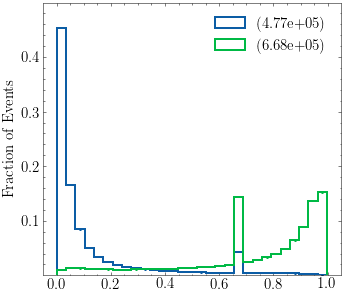

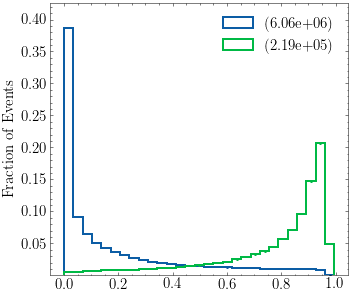

In [12]:
hist_multi([node_metrics.pred[node_metrics.true==0],node_metrics.pred[node_metrics.true==1]],density=1)
hist_multi([edge_metrics.pred[edge_metrics.true==0],edge_metrics.pred[edge_metrics.true==1]],density=1)

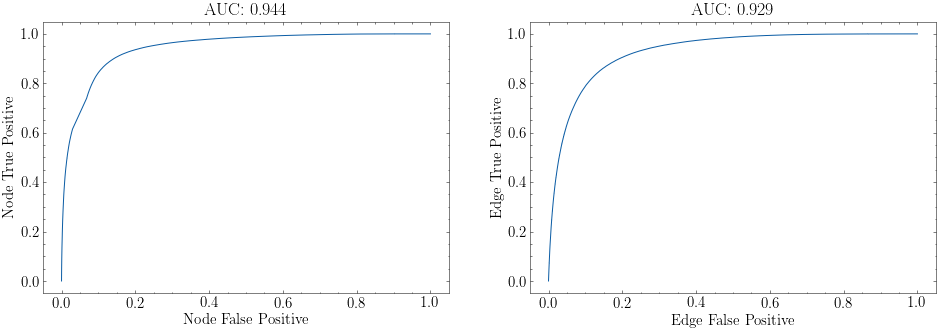

In [17]:
fig,ax = gnn.plot_graph_auroc(node_metrics,edge_metrics)